In [1]:
import numpy as np
import sympy as sp
from scipy.linalg import inv
import matplotlib.pyplot as ply
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad
from scipy.linalg import eig

# Definindo variáveis simbólicas
x, y, z = sp.symbols('x y z')

# Definindo parâmetros de entrada

E_1 = 38000    # [N/mm^2] [MPa]
E_2 = 9000     # [N/mm^2] [MPa]
G_12 = 3600    # [N/mm^2] [MPa]
v_12 = 0.32
v_21 = E_2*v_12/E_1

X_t = 1062 #[MPa]
X_c = 985 #[MPa]
Y_t = 31 #[MPa]
Y_c = 118 #[MPa]
S_12 = 78 #[MPa]


# Definição das variáveis
a = 20 # [mm]  X axis
b = 20 # [mm]  Y axis

Nx = 400  #[Newton/mm]
Ny = 200  #[Newton/mm]
Nxy = 50  #[Newton/mm]
Mx = 0       #[Newton.mm]
My = 0       #[Newton.mm]
Mxy = 0      #[Newton.mm]

Fx = Nx/a # Corga por unidade de comprimento (Nx/a)
Fy = Ny/b # Corga por unidade de comprimento (Ny/b)

t = 1.1 # Espessura de cada lâmina, em [mm]

M = 3  # Ordem de iteração para o campo de deslocamento Nw

# Orientação das camadas do skin, em [°]
skin = [20, -40, -20, 40]

n = len(skin)  # Número de camadas - skin


In [2]:
# Calculando a posição z de cada camada no skin 
Nz = []
for i in range(1, n+2):
    Nz.append((i - ((n/2) + 1)) * t)

# Diferenças entre espessuras no skin
d = []
dd = []
ddd = []
for j in range(1, n + 1):
    k = j - 1
    d.append(Nz[j] - Nz[k])
    dd.append(0.5 * (Nz[j]**2 - Nz[k]**2))
    ddd.append((1/3) * (Nz[j]**3 - Nz[k]**3))


# Matrizes A, B e D do skin
A = np.zeros((3, 3))
B = np.zeros((3, 3))
D = np.zeros((3, 3))


for i in range(n):
    theta_rad = np.radians(skin[i])  # Converte para radianos
    cos_theta = np.cos(theta_rad)
    sin_theta = np.sin(theta_rad)

    E_x = 1 / ((1 / E_1) * (cos_theta**4) + (1 / E_2) * (sin_theta**4) + ((1 / G_12) - (2 * v_12 / E_1)) * (cos_theta * sin_theta)**2)
    E_y = 1 / ((1 / E_1) * (sin_theta**4) + (1 / E_2) * (cos_theta**4) + ((1 / G_12) - (2 * v_12 / E_1)) * (cos_theta * sin_theta)**2)
    v_xy = E_x * ((v_12 / E_1) * (cos_theta**4 + sin_theta**4) - ((1 / E_1) + (1 / E_2) - (1 / G_12)) * ((cos_theta**2) * (sin_theta**2)))
    G_xy = 1 / (4 * ((1 / E_1) + (1 / E_2) + (2 * v_12 / E_1)) * ((cos_theta**2) * (sin_theta**2)) + (1 / G_12) * ((cos_theta**2 - sin_theta**2)**2))
    
    etha_E_x = (2 * ((1 / E_1) + (v_12 / E_1)) * (cos_theta**3) * sin_theta) - (2 * ((v_12 / E_1) + (1 / E_2)) * cos_theta * (sin_theta**3)) - (1 / G_12) * cos_theta * sin_theta * ((cos_theta**2) - (sin_theta**2))
    etha_E_y = (2 * ((1 / E_1) + (v_12 / E_1)) * (sin_theta**3) * cos_theta) - (2 * ((v_12 / E_1) + (1 / E_2)) * sin_theta * (cos_theta**3)) + (1 / G_12) * cos_theta * sin_theta * ((cos_theta**2) - (sin_theta**2))

    S_xx = np.array([[1 / E_x, -v_xy / E_x, etha_E_x], [-v_xy / E_x, 1 / E_y, etha_E_y], [etha_E_x, etha_E_y, 1 / G_xy]])
    Q_xx = inv(S_xx)

    A += d[i] * Q_xx
    B += dd[i] * Q_xx
    D += ddd[i] * Q_xx

A_inverse = inv(A)

t_equi = n*t
    
Ex_equi = 1/(A_inverse[0][0]*n*t)

Ey_equi = 1/(A_inverse[1][1]*n*t)

Gxy_equi = 1/(A_inverse[2][2]*n*t)

Vxy_equi = -A_inverse[0][1]/A_inverse[0][0]

Alphaxs_equi = A_inverse[0][2]/A_inverse[0][0]

Alphays_equi = A_inverse[1][2]/A_inverse[1][1]

print(f' Matrix A \n {A}\n')

if A[0][2]<10e-5 and A[1][2]<10e-5:
    print('There is NOT coupling between Shear and Bending effects !!! \n\n')
else:
    print('There is coupling between Shear and Bending effects !!! \n\n')


print(f' Matrix B \n {B}\n')

if all(B[i][j] < 10e-5 for i in range(3) for j in range(3)):
    print('There is NOT coupling between Membrane and Bending effects !!! \n\n')
else:
    print('There is coupling between Membrane and Bending effects !!! \n\n')
    

print(f'Matrix D \n {D}\n')

if D[0][2]<10e-5 and D[1][2]<10e-5:
    print('There is NOT coupling between Twist and Bending effects !!! \n\n')
else:
    print('There is coupling between Twist and Bending effects !!! \n\n')

print('MEMBRANE PROPERTIES\n')

print(skin)

print('\n')

print(f't equivalent: {t_equi}\n')

print(f'Ex equivalent: {Ex_equi}\n')

print(f'Ey equivalent: {Ey_equi}\n')

print(f'Gxy equivalent: {Gxy_equi}\n')

print(f'Vxy equivalent: {Vxy_equi}\n')

print(f'Alphaxs equivalent: {Alphaxs_equi}\n')

print(f'Alphays equivalent: {Alphays_equi}\n')



 Matrix A 
 [[1.15495437e+05 3.41828502e+04 0.00000000e+00]
 [3.41828502e+04 5.40529045e+04 0.00000000e+00]
 [0.00000000e+00 9.09494702e-13 3.70358820e+04]]

There is NOT coupling between Shear and Bending effects !!! 


 Matrix B 
 [[-15344.20152772   4692.27172116    731.72585856]
 [  4692.27172116   5959.6580854   11568.06322385]
 [   731.72585856  11568.06322385   4692.27172116]]

There is coupling between Membrane and Bending effects !!! 


Matrix D 
 [[186332.63799302  55148.33162268  44494.99997733]
 [ 55148.33162268  87205.35254028  19890.06058038]
 [ 44494.99997733  19890.06058038  59751.22300095]]

There is coupling between Twist and Bending effects !!! 


MEMBRANE PROPERTIES

[20, -40, -20, 40]


t equivalent: 4.4

Ex equivalent: 21335.984767214588

Ey equivalent: 9985.433005508048

Gxy equivalent: 8417.245914859317

Vxy equivalent: 0.6323961777140714

Alphaxs equivalent: -0.0

Alphays equivalent: -0.0



In [7]:

for i in range(n):
    theta_rad = np.radians(skin[i])  # Converte para radianos
    cos_theta = np.cos(theta_rad)
    sin_theta = np.sin(theta_rad)

    Q_12 = np.array([[E_1 / (1-v_12*v_21), (v_12*E_2) / (1-v_12*v_21), 0], [v_12*E_2/(1-v_12*v_21), E_2/(1-v_12*v_21), 0], [0, 0, G_12]])
    T = np.array([[cos_theta**2, sin_theta**2, sin_theta*cos_theta], [sin_theta**2, cos_theta**2, -sin_theta*cos_theta], [-2*sin_theta*cos_theta, 2*sin_theta*cos_theta, cos_theta**2-sin_theta**2]])

    T_stress = np.array([[cos_theta**2, sin_theta**2, 2*sin_theta*cos_theta], [sin_theta**2, cos_theta**2, -2*sin_theta*cos_theta], [-sin_theta*cos_theta, sin_theta*cos_theta, cos_theta**2-sin_theta**2]])
    
    # Stiffeners Matrix Global System
    Q_xy = (T.T)@Q_12@T

    linha1 = np.concatenate((A, B), axis=1)
    linha2 = np.concatenate((B, D), axis=1)
    ABD = np.concatenate((linha1, linha2), axis=0)
    ABD_inverse = inv(ABD)
    A_inv = np.array(ABD_inverse[:3, :3])
    B_inv = np.array(ABD_inverse[3:, :3])

    strain_0 = np.array(A_inv@[[Nx],[Ny],[Nxy]])
    k = np.array(B_inv@[[Nx],[Ny],[Nxy]])
    
    #strain_global = (strain_0+(Nz[i])*k)
    strain_global = (strain_0+((Nz[i]+Nz[i+1])/2)*k)
    strain_local = T@strain_global
    stress_global = Q_xy@strain_global
    stress_local = T_stress@stress_global

    Tsai_hill = (stress_local[0]/X_t)**2-(stress_local[0]*stress_local[1]/(X_t**2))+(stress_local[1]/Y_t)**2+(stress_local[2]/S_12)**2

    
    F_1 = (1/X_t)-(1/X_c)
    F_11 = 1/(X_t*X_c)
    F_2 = (1/Y_t)-(1/Y_c)
    F_22 = 1/(Y_t*Y_c)
    F_66 = 1/(S_12**2)
    F_12 = -((F_11*F_22)**(1/2))/2
    Tsai_wu = F_1*stress_local[0]+F_2*stress_local[1]+F_11*stress_local[0]**2+F_22*stress_local[1]**2+F_66*stress_local[2]**2+2*F_12*stress_local[0]*stress_local[1]
    
    print(f'ply Identification: {i+1}\n')
    print(f'Q_12 \n {Q_12}\n')
    print(f'Transformation \n {T}\n')
    print(f'Q_xy \n {Q_xy}\n')

    print(f'strain_global [mm]\n {strain_global}\n')
    print(f'strain_local [mm]\n {strain_local}\n')
    print(f'stress_global [MPa]\n {stress_global}\n') 
    print(f'stress_local [MPa]\n {stress_local}\n')
    

    if Tsai_hill <1:
        print(f'Tsai-Hill Index Ply\n {Tsai_hill}\n') 
        print(f'There is NOT fail in the ply {i+1} !!! \n\n')
    else:
        print(f'Tsai-Hill Index Ply\n {Tsai_hill}\n') 
        print(f'There is fail in the ply {i+1} !!! \n\n')

    if Tsai_wu <1:
        print(f'Tsai-wu Index Ply\n {Tsai_wu}\n') 
        print(f'There is NOT fail in the ply {i+1} !!! \n\n')
    else:
        print(f'Tsai-wu Index Ply\n {Tsai_wu}\n') 
        print(f'There is fail in the ply {i+1} !!! \n\n')


ply Identification: 1

Q_12 
 [[38944.50677483  2951.58367136     0.        ]
 [ 2951.58367136  9223.69897299     0.        ]
 [    0.             0.          3600.        ]]

Transformation 
 [[ 0.88302222  0.11697778  0.3213938 ]
 [ 0.11697778  0.88302222 -0.3213938 ]
 [-0.64278761  0.64278761  0.76604444]]

Q_xy 
 [[32589.54204654  5829.87432954  8206.25498364]
 [ 5829.87432954  9822.08238492  1345.82851881]
 [ 8206.25498364  1345.82851881  6478.29065818]]

strain_global [mm]
 [[0.00202761]
 [0.00317772]
 [0.00288929]]

strain_local [mm]
 [[0.00309075]
 [0.00211458]
 [0.0029526 ]]

stress_global [MPa]
 [[108.31487971]
 [ 46.92102119]
 [ 39.63341284]]

stress_local [MPa]
 [[126.60902924]
 [ 28.62687166]
 [ 10.62934989]]

Tsai-Hill Index Ply
 [0.882325]

There is NOT fail in the ply 1 !!! 


Tsai-wu Index Ply
 [0.87085891]

There is NOT fail in the ply 1 !!! 


ply Identification: 2

Q_12 
 [[38944.50677483  2951.58367136     0.        ]
 [ 2951.58367136  9223.69897299     0.        ]

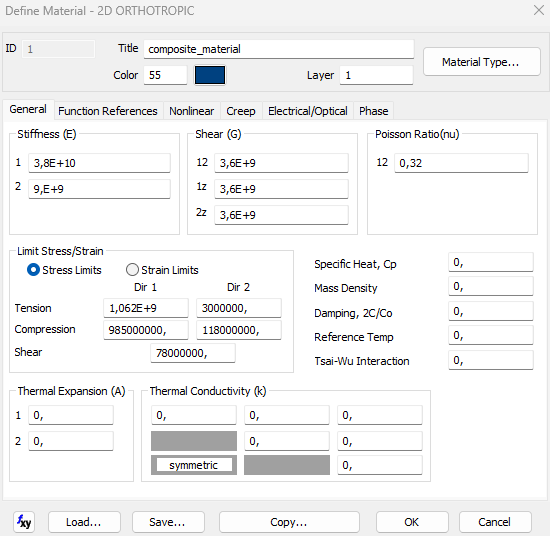

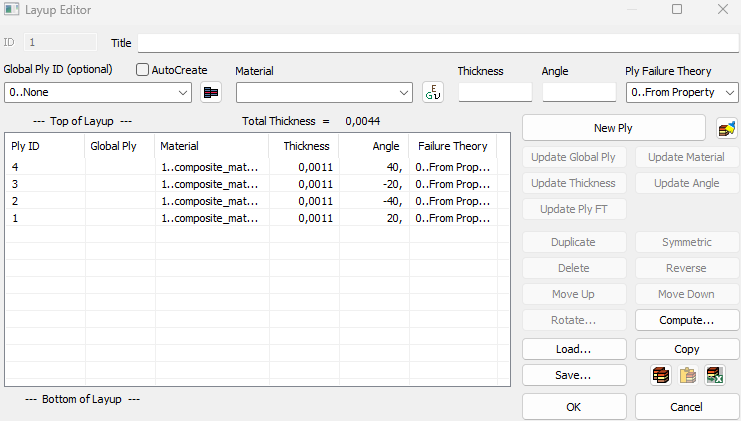

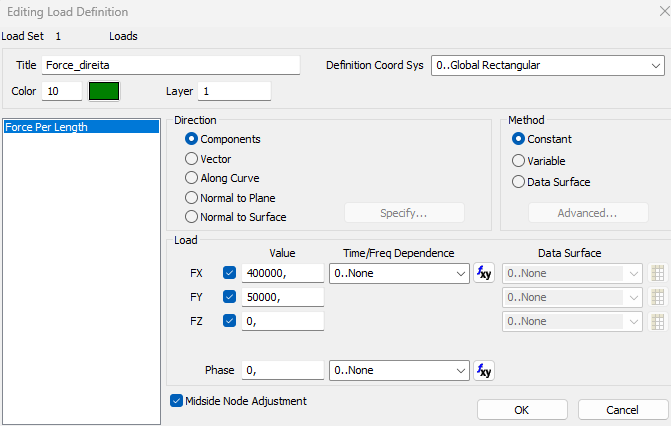
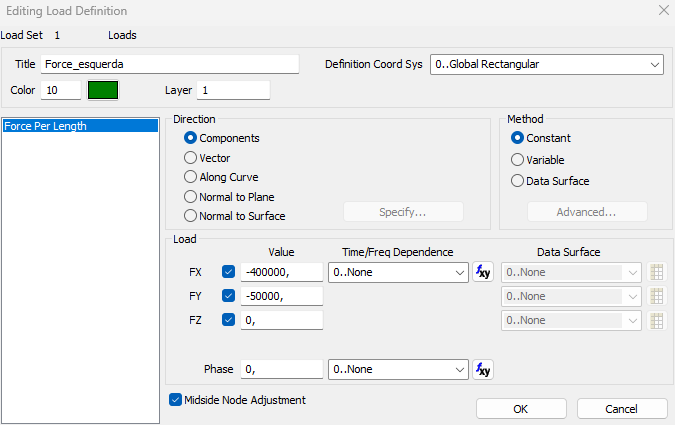
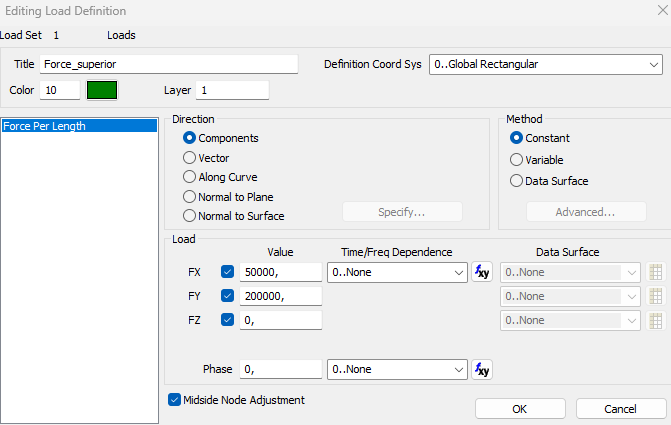
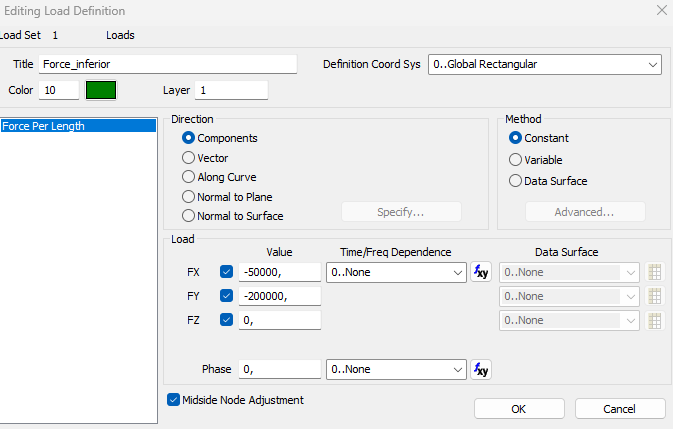

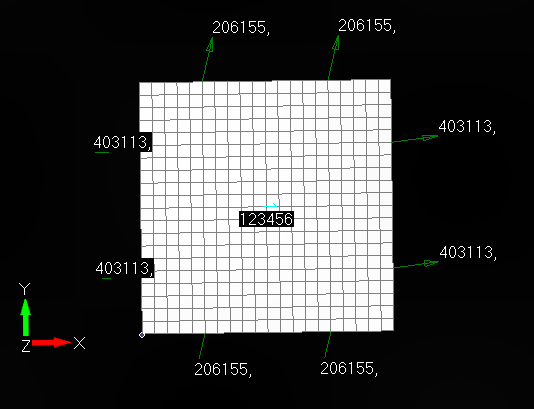

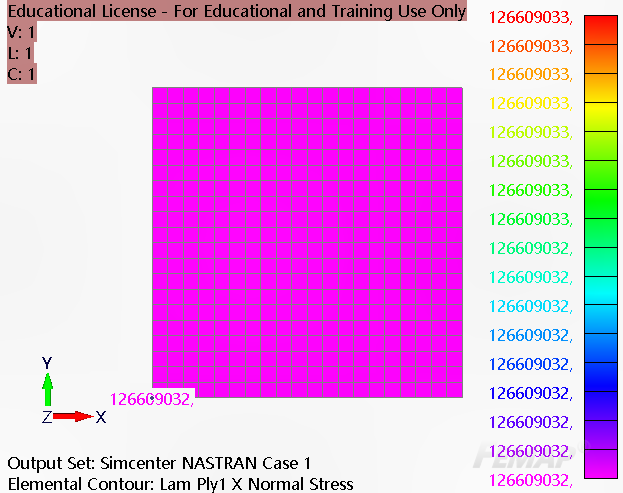
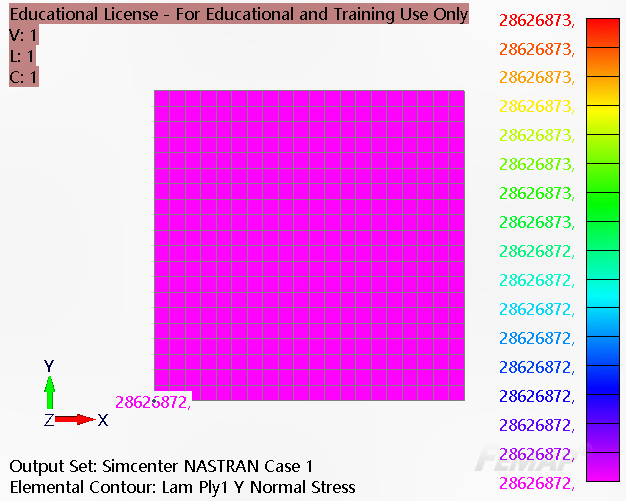
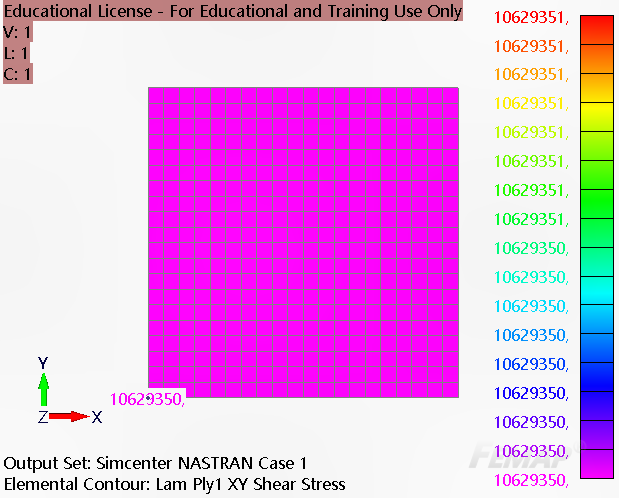

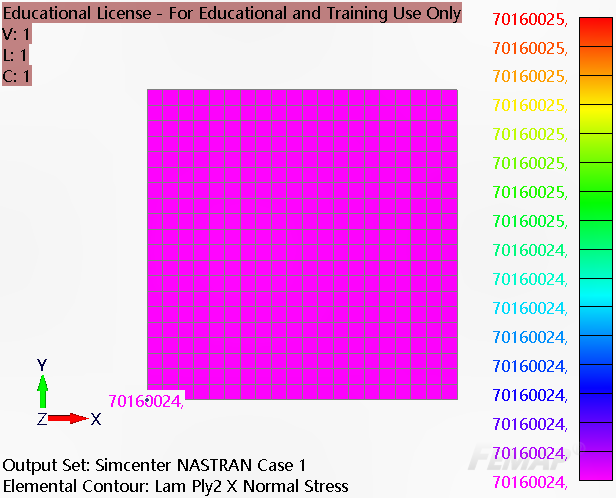
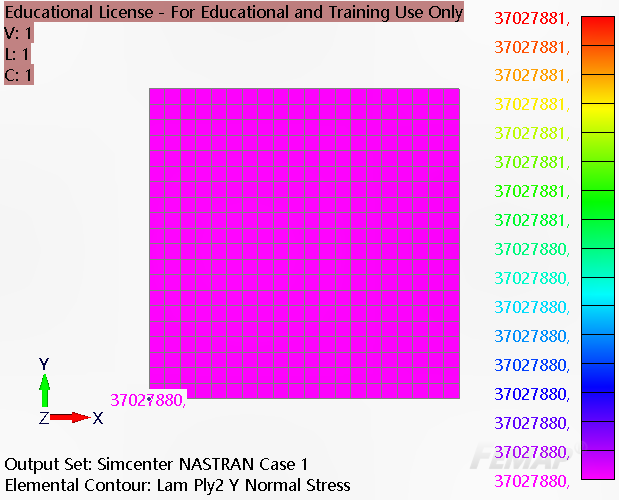
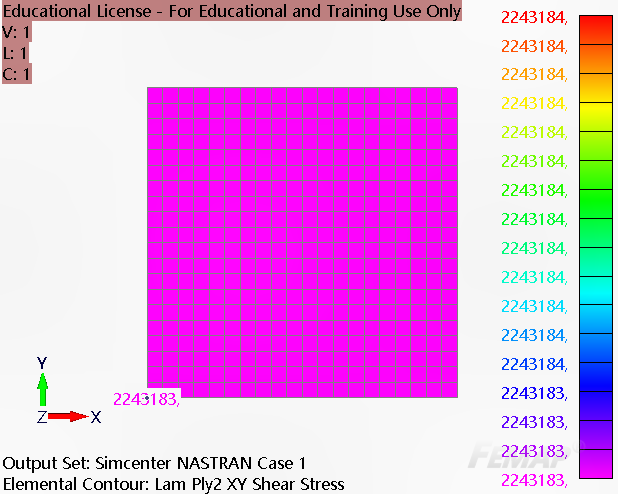

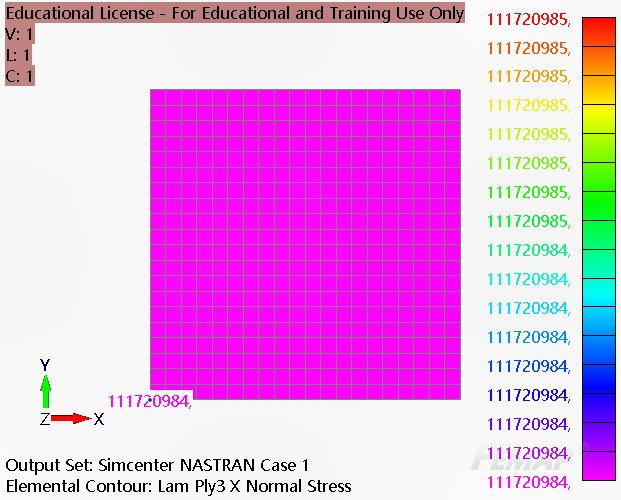
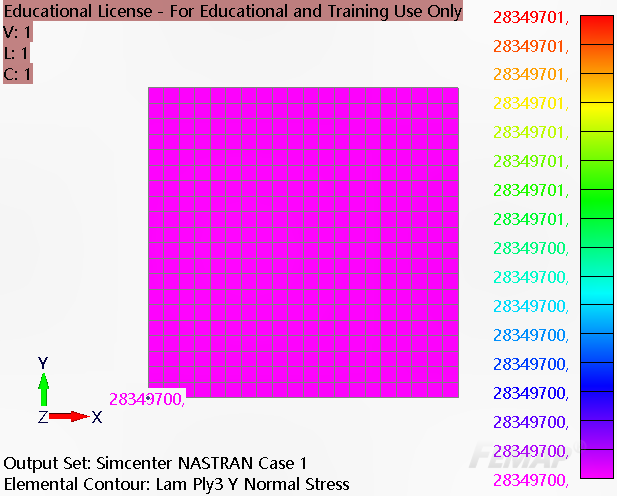
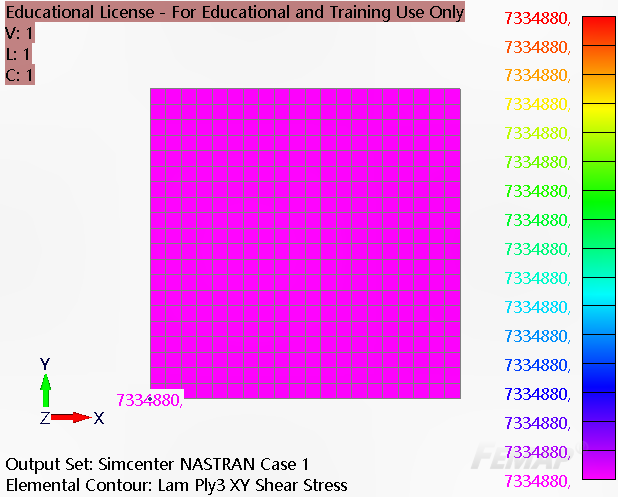

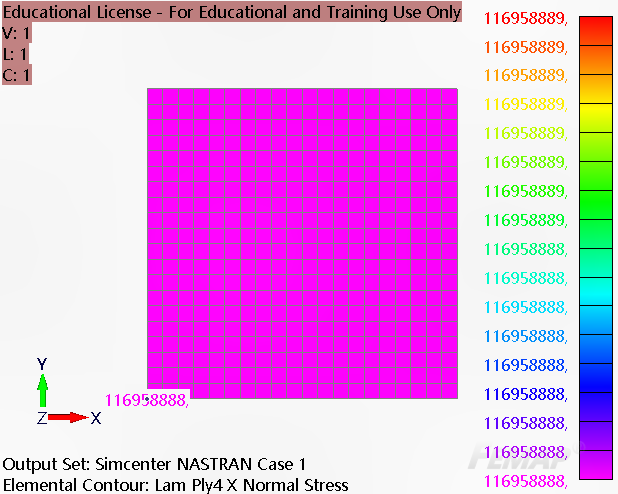
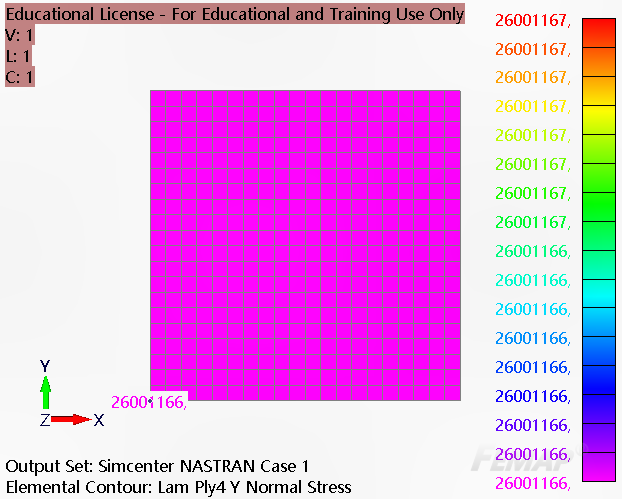
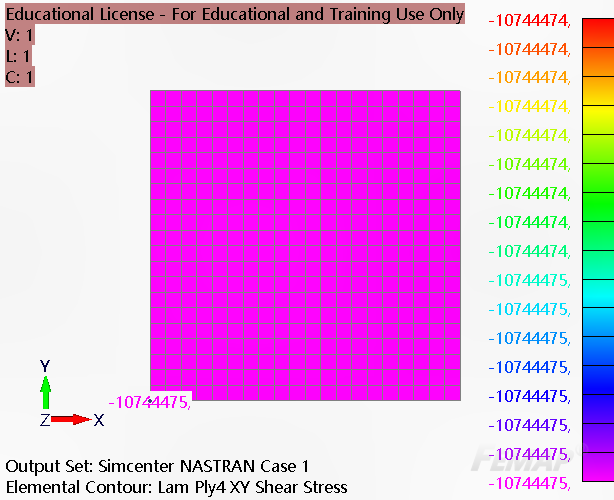